# Inferring historical populations sizes using PSMC

The Pairwise Sequentially Markovian Coalescent (PSMC) model uses information in the complete diploid sequence of a single individual to infer the history of population size changes. The method was published in 2011 ([Li and Durbin 2011](https://www.nature.com/articles/nature10231)). It has become a very popular tool in the world of genomics. In this exercise, we first walk through the steps to generate the necessary input data for PSMC. Then we run PSMC on chromosome 2 of an individual from the Simons Diversity Panel and plot the results.

For additional detail on how to run PSMC see the [GitHub page](https://github.com/lh3/psmc) for PSMC source code.

The method used for base calling in an earlier exercise is state of the art. Unfortunately, to produce the input data for PSMC we cannot just use the base calls or VCF files that we already produced. The first reason is that PSMC required more data than the 10Mb of chromosome 2 that you called bases on. The second reason is that the way you did your base calls do not let us easily produce input data for PSMC, which is a consensus sequence that represents the diploid genome. 

The files we are goint to use are the following:
- BAM file: Data/bam/S_Hungarian-2.chr2.bam
- BAI file: Data/bam/S_Hungarian-2.chr2.bam.bai
- Fasta file: Reference/chr2.fa

## Background material

To better understand historical demographic inference with Sequential Markov Coalescent techniques, please watch and read the following:

* A talk on historic demographic inference using Sequential Markov Coalescent. by Thomas Mailund (BiRC AU). [Watch here](https://www.youtube.com/watch?v=Oogc_HJ6hjw)

* [Mather et al 2019](https://onlinelibrary.wiley.com/doi/full/10.1002/ece3.5888) An introduction article to Sequential Markov Coalescent

* The `psmc` paper [Li and Durbin 2011](https://www.nature.com/articles/nature10231)

## How to make this notebook work

* In this notebook we will use both the `command line bash` commands and `R` to setup the file folders.
* Having to shift between two languages, you need to choose a kernel every time we shift from one language to another. A kernel contains a programming language and the necessary packages to run the course material. To choose a kernel, go on the menu on the top of the page and select `Kernel --> Change Kernel`, and then select the preferred one. We will shift between two kernels, and along the code in this notebook you will see a picture telling you to change kernel. The two pictures are below:

<img src="img/bash.png" alt="Bash" width="80"> Shift to the `Bash` kernel

<img src="img/R.png" alt="R" width="80"> Shift to the `popgen course` kernel
* You can run the code in each cell by clicking on the run cell sign in the toolbar, or simply by pressing <kbd>Shift</kbd>+<kbd>Enter</kbd>. When the code is done running, a small green check sign will appear on the left side.
* You need to run the cells in sequential order to execute the analysis. Please do not run a cell until the one above is done running, and do not skip any cells
* The code goes along with textual descriptions to help you understand what happens. Please try not to focus on understanding the code itself in too much detail - but rather try to focus on the explanations and on the output of the commands 
*   You can create new code cells by pressing `+` in the Menu bar above or by pressing <kbd>B</kbd> after you select a cell. 


## Learning outcomes

At the end of this tutorial you will be able to

- **Understand** the principle behind the use of Sequential Markov Coalescent techniques and `pscm` for demographic inference 
- **Prepare and analyze** data using `psmc`
- **Compare** the historical population size of different populations


## Setting up folders

Here we setup a link to the `Data` and `Reference` folders, and create the `Results` folder

<img src="img/bash.png" alt="Bash" width="80"> Choose the `Bash` kernel

In [6]:
ln -s ../../Data
ln -s ../../Reference
mkdir -p Results

The example individual used below is a Hungarian individual with id ERR1025630. If you want to try on another individual, remember to check the id in the metadata file.

Starting from mapped reads, the first step is to produce a consensus sequence in FASTQ format, which stores both the sequence and its corresponding quality scores, that will be used for QC filtering. The consensus sequence has A, T, C or G at homozygous sites, and other letters [IUPAC codes](https://www.bioinformatics.org/sms/iupac.html) to represent heterozygotes. To make the consensus calls, we use the samtools/bcftools suite. We first use `samtools mpileup` to get the pileup of reads for each position. We then generate a consensus sequence with `bcftools`, which we convert to FASTQ (with some additional filtering) by `vcfutils.pl`. We take advantage of Unix pipes and the ability of `samtools` to work with streaming input and output to run the whole pipeline (`samtools` -> `bcftools` -> `vcfutils.pl`) as one command. We run our consensus calling pipeline, consisting of a linked set of `samtools`, `bcftools`, and `vcfutils.pl` commands ([see here](https://samtools.github.io/bcftools/howtos/consensus-sequence.html)).

This might take a long to run (about 5-6 hours) so if you get tired of waiting you can press the stop button in the toolbar, and get the output file here:

```bash
Data/consensus_fastq/S_Hungarian-2.chr2.fq
```

The same folder contains the other individuals for the populations in use.

In [8]:
bcftools mpileup -Q 30 -Ou -q 30 -f Data/fasta/chr2.fa -r 2 Data/bam/S_Hungarian-2.chr2.bam | \
bcftools call --threads 8 -c - | \
vcfutils.pl vcf2fq -d 5 -D 100 -Q 30 | \
gzip > Results/S_Hungarian-2.chr2.fq

Note: none of --samples-file, --ploidy or --ploidy-file given, assuming all sites are diploid
[mpileup] 1 samples in 1 input files



The command above takes as input an aligned bam file and a reference genome, generates a summary of the coverage of mapped reads on a reference sequence at a single base pair resolution using `bcftools mpileup`, then calls the consensus sequence with `bcftools`, and then filters and converts the consensus to FASTQ format. Some parameter explanations:

1. `mpileup`:
    - `-Q` and `-q` in mpileup determine the cutoffs for baseQ and mapQ, respectively
    - `-Ou` tells bcftools to output as an intermediate file to pipe to bcftools
    - `-f` is the reference fasta used 
    - `-r` is the region to call the mpileup for (in this case, a particular chromosome)
2. `bcftools`:
    - call `-c` calls a consensus sequence from the mpileup using the original calling method
3. `vcfutils.pl`:
    - `-d 5` and `-D 100` determine the minimum and maximum coverage to allow for `vcf2fq`, anything outside that range is filtered
    - `-Q 30` sets the root mean squared mapping quality minimum to 30

## Create a PSMC input file

PSMC takes the consensus FASTQ file, and infers the history of population sizes, but first we need to convert this FASTQ file to the input format for PSMC. This transforms the consensus sequence into a fasta-like format where the i-th character in the output sequence indicates whether there is at least one heterozygote in the bin [100i, 100i+100). Have a look at the file using `less`.

In [11]:
fq2psmcfa -q20 Data/consensus_fastq/S_Hungarian-2.chr2.fq > Results/S_Hungarian-2.chr2.psmcfa

In [1]:
less Results/S_Hungarian-2.chr2.psmcfa | head

>2
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNTTKTKTTNNKKKTKTKK
KKTKKTKTTKTKTTTTKKTTTTTTKTTTTKTTTTKKTKTTTTTTTTTTTKTTTTTTTTTT
TTTTTKKTTTTTTTTTTTTKTTTTTTTTTTTTKKKTTTKTTTKKTTTTTTTTTTTTTTTT
TTTTTTTTKTTTTTTTTTKTTTTTTTTTKTTTTTTKTTTTTTKTTTTKTTKTTTKTTTTK
KTTTTTTTTKTTTKTTTKTTTTTTTTTTTTKTTTTTTTTTKTTTTKTTTTTTTTTTTTTT
TTTTTTTKTTKTTKTTTTTTTKTTTTTTTTTTTKTTTTTTTTTTTKTTTTTTTTKTTTTT
TTTTTTTTTTKTKKTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
TTTTTTTTTTTTTTKTTTTTKTTTTTTTKTTTTTTTKTTTTKTTTTTTTTTTTTTTKTTT


## Execute PSMC

Now we are setup to run PSMC. The command line below has been shown to be suitable for modern humans, inappropiate settings might lead to under/over-fitting. The `-p` and `-t` options are used to specify the length and number of time intervals. The `-r` option is used to specify the initial theta/rho ratio. The `-N` option sets the maximum number of EM iterations in the fitting of model parameters.

This PSMC analysis takes about 25 minutes to complete. 

In [5]:
psmc -N50 -t15 -r5 -p "4+25*2+4+6" -o Results/S_Hungarian-2.chr2.psmc Results/S_Hungarian-2.chr2.psmcfa

Below, we create an output plot of the PSMC inference. The `-u` option specifies the per year mutation rate and the `-g` the generation time. The `-R` option preserves the intermediate files the script produces. The latter is handy if you want to make plots yourself combining several PSMC analyses. We will use those in `R`.

In [12]:
psmc_plot.pl -R -u 1.2e-08 -g 25 Results/S_Hungarian-2.chr2 Results/S_Hungarian-2.chr2.psmc

We run the same scripts for another individual so that we can compare two populations.

In [14]:
fq2psmcfa -q20 Data/consensus_fastq/S_Ju_hoan_North-3.chr2.fq > Results/S_Ju_hoan_North-3.chr2.psmcfa
psmc -N50 -t15 -r5 -p "4+25*2+4+6" -o Results/S_Ju_hoan_North-3.chr2.psmc Results/S_Ju_hoan_North-3.chr2.psmcfa
psmc_plot.pl -R -u 1.2e-08 -g 25 Results/S_Ju_hoan_North-3.chr2 Results/S_Ju_hoan_North-3.chr2.psmc

## Compare individuals from different regions of the world

We want to compare individuals from different regions. Thus, we plot all results together in a R jupyter notebook. Try out the code below. where we open the intermediate files from `psmc` for two populations and compare the historical population size in a plot.

<img src="img/R.png" alt="R" width="80"> Shift to the `popgen course` kernel

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 24 row(s) containing missing values (geom_path).”


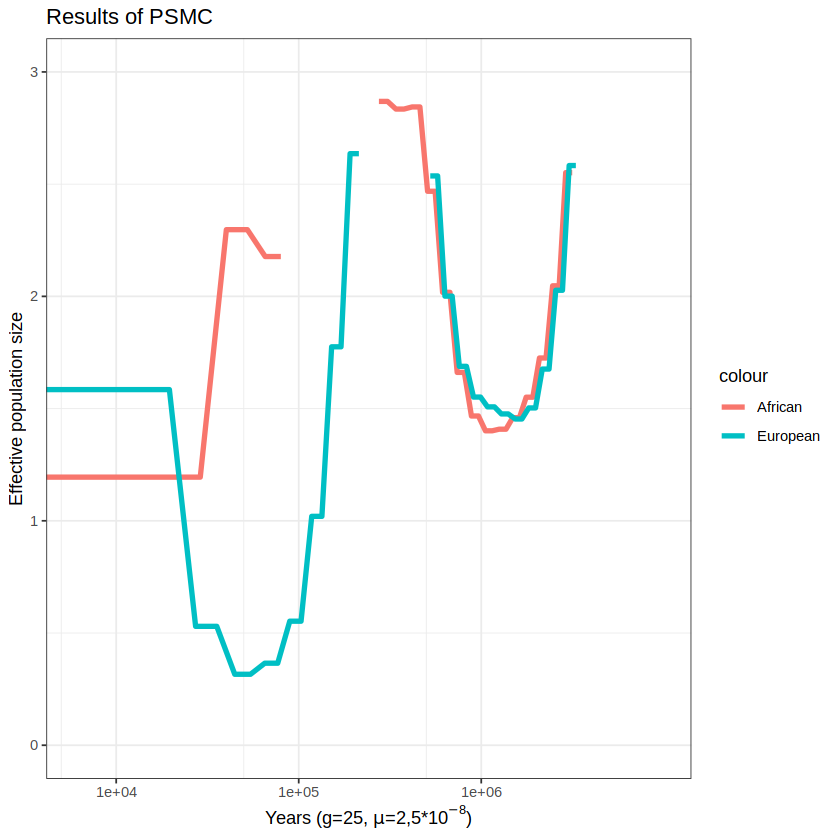

In [1]:
library(ggplot2)

psmc_data1 <- read.table("Results/S_Hungarian-2.chr2.0.txt", header=F, col.names = c('Years', 'Effective_pop_size', 'X', 'Y', 'C'))
psmc_data2 <- read.table("Results/S_Ju_hoan_North-3.chr2.0.txt", header=F, col.names = c('Years', 'Effective_pop_size', 'X', 'Y', 'C'))

# If data 1 is African and data2 is European you can type: 

psmc_data1$region = 'European'
psmc_data2$region = 'African'

d = data.frame(
                Region = c(psmc_data1$region, psmc_data2$region), 
                Years = c(psmc_data1$Years, psmc_data2$Years), 
                Effective_pop_size = c(psmc_data1$Effective_pop_size,psmc_data2$Effective_pop_size)
                )

ggplot(d, aes(x=Years, y=Effective_pop_size, color="NCL-08")) + 
  geom_line(aes(color=Region), size=1.5) + 
  theme_bw() + 
  labs(x= expression(paste("Years (g=25, ", mu, "=2,5*", 10^-8,")")), y="Effective population size", title='Results of PSMC') +
  scale_x_log10(breaks=c(1000, 10000, 100000, 1000000), minor_breaks=c(500, 5000, 50000, 500000)) +
  scale_y_continuous(limits = c(0,3))